In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

In [118]:
df = pd.read_csv("load.csv")
df = df.rename(columns={"Selecione Tipo de CE Simp 4":'load',"Day of Data Escala de Tempo 1 CE Simp 4":"date"})
df['date'] = pd.to_datetime(df['date'], format='%B %d, %Y', errors='coerce')
df = df[df['date'] > pd.Timestamp("2020-12-31")]
df.index = df['date']
df = df.drop(['Subsistema','Data Escala de Tempo 1 CE Simp 4','Período Exibido CE Simp 4'],axis=1)

In [119]:
'''This step uses feature engineering to extract some good features for the 
 ARIMA model and the classical ones that will be developed in this project'''

df['day_of_week'] = df['date'].dt.weekday
df['month'] = df['date'].dt.month
df['day_of_month'] = df['date'].dt.day
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

# Sine/Cosine encoding for month seasonality
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Lag features
df['load_lag_1'] = df['load'].shift(1)
df['load_lag_7'] = df['load'].shift(7)
df['load_lag_30'] = df['load'].shift(30)

# Moving average
df['load_7ma'] = df['load'].shift(1).rolling(window=7).mean()

# Daily load change
df['load_change'] = df['load'] - df['load'].shift(1)

# Example: Adding holidays (replace with your country’s calendar)
brazil_holidays = ['2024-01-01', '2024-02-12', '2024-02-13', '2024-04-21', '2024-12-25']
df['is_holiday'] = df['date'].dt.strftime('%Y-%m-%d').isin(brazil_holidays).astype(int)

# Drop NA rows caused by shifting
df = df.dropna()
# df = df.drop('date',axis=1)

df.head()


,date,load,day_of_week,month,day_of_month,is_weekend,month_sin,month_cos,load_lag_1,load_lag_7,load_lag_30,load_7ma,load_change,is_holiday
date,,,,,,,,,,,,,,
2021-01-31,2021-01-31,941.754101,6,1,31,1,0.500000,0.866025,1018.457131,890.358774,778.079039,1033.230625,-76.703030,0
2021-02-01,2021-02-01,1075.885799,0,2,1,0,0.866025,0.500000,941.754101,1015.052041,812.376498,1040.572815,134.131698,0
2021-02-02,2021-02-02,1091.444503,1,2,2,0,0.866025,0.500000,1075.885799,1055.141035,784.189436,1049.263352,15.558704,0
2021-02-03,2021-02-03,1095.639246,2,2,3,0,0.866025,0.500000,1091.444503,1077.005876,916.627172,1054.449562,4.194743,0
2021-02-04,2021-02-04,1115.780680,3,2,4,0,0.866025,0.500000,1095.639246,1085.843911,982.955593,1057.111472,20.141434,0


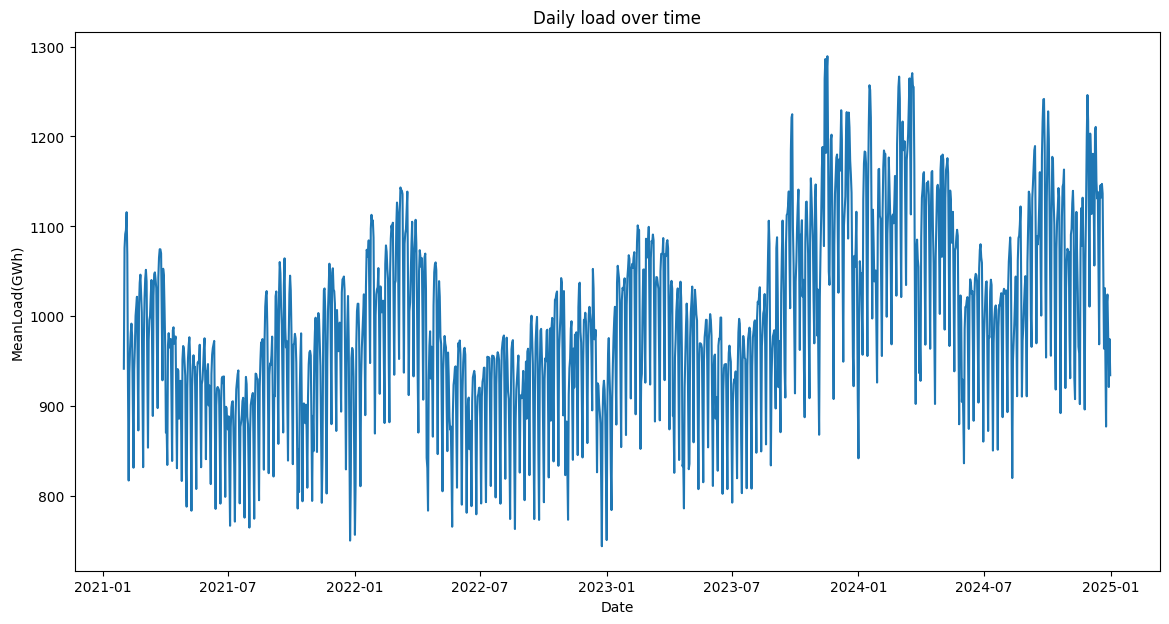

In [120]:
plt.figure(figsize=(14, 7))

plt.plot(df.index, df["load"])
plt.title('Daily load over time')
plt.xlabel('Date')
plt.ylabel('MeanLoad(GWh)')

plt.show()

In [121]:
###Insert plot year by year to have higher resolution

ADF Statistic: -3.0949244867083716
p-value: 0.026931086434162158
✅ Data is stationary (p-value ≤ 0.05)


<Figure size 1200x500 with 0 Axes>

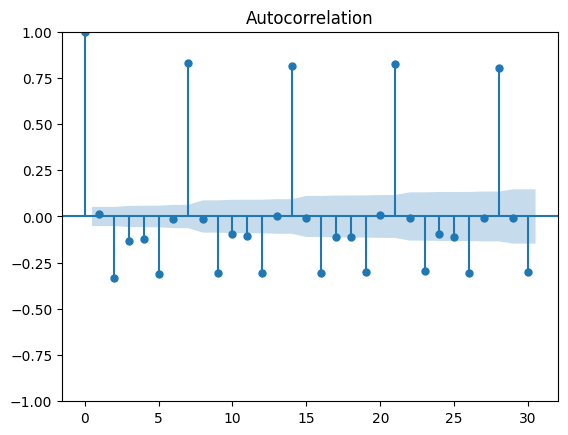

In [122]:
#Check data stationarity for ARIMA  

#Augmented Dickey-Fuller (ADF) Test
result = adfuller(df['load'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] <= 0.05:
    print("✅ Data is stationary (p-value ≤ 0.05)")
else:
    print("❌ Data is non-stationary (p-value > 0.05)")

df['load_diff'] = df['load'] - df['load'].shift(1)

plt.figure(figsize=(12, 5))
plot_acf(df['load_diff'].dropna(), lags=30)
plt.title("Autocorrelation")
plt.show()

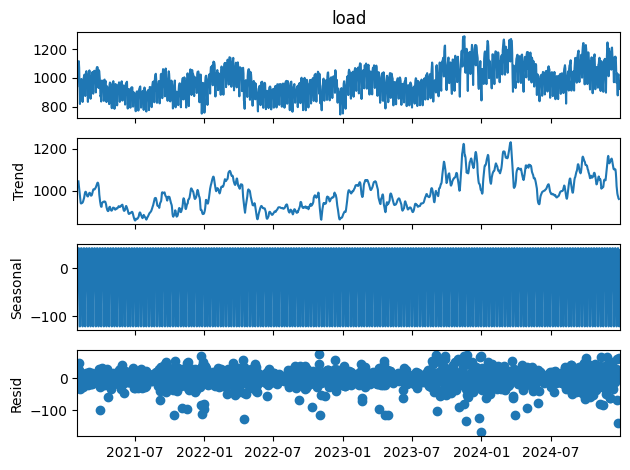

In [123]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['load'], period=7)
decomposition.plot()
plt.show()


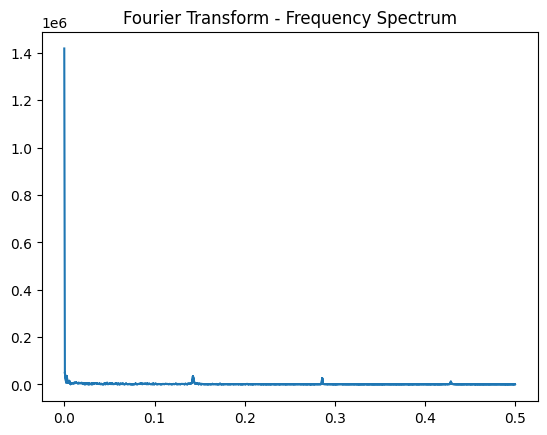

In [124]:
fft_vals = np.fft.fft(df['load'])
fft_freqs = np.fft.fftfreq(len(df))

plt.plot(np.abs(fft_freqs), np.abs(fft_vals))
plt.title("Fourier Transform - Frequency Spectrum")
plt.show()

In [132]:
# Resample to weekly, monthly, and yearly averages
df_daily = df.copy()
df_weekly = df.resample('W', on='date').mean()
df_monthly = df.resample('ME', on='date').mean()
df_yearly = df.resample('YE', on='date').mean()


def adf_check(series, title=''):
    result = adfuller(series.dropna())
    print(f'{title} ADF Statistic: {result[0]:.2f}')
    print(f'{title} p-value: {result[1]:.2f}')
    if result[1] <= 0.05:
        print(f"✅ {title} data is stationary (p ≤ 0.05)\n")
    else:
        print(f"❌ {title} data is NOT stationary (p > 0.05)\n")

# Run ADF on each resampled data
adf_check(df_daily['load'], 'Daily Data')
adf_check(df_weekly['load'], 'Weekly Data')
adf_check(df_monthly['load'], 'Monthly Data')
adf_check(df_yearly['load'], 'Yearly Data')


Daily Data ADF Statistic: -3.09
Daily Data p-value: 0.03
✅ Daily Data data is stationary (p ≤ 0.05)

Weekly Data ADF Statistic: -2.20
Weekly Data p-value: 0.21
❌ Weekly Data data is NOT stationary (p > 0.05)

Monthly Data ADF Statistic: -2.19
Monthly Data p-value: 0.21
❌ Monthly Data data is NOT stationary (p > 0.05)

Yearly Data ADF Statistic: 1.33
Yearly Data p-value: 1.00
❌ Yearly Data data is NOT stationary (p > 0.05)



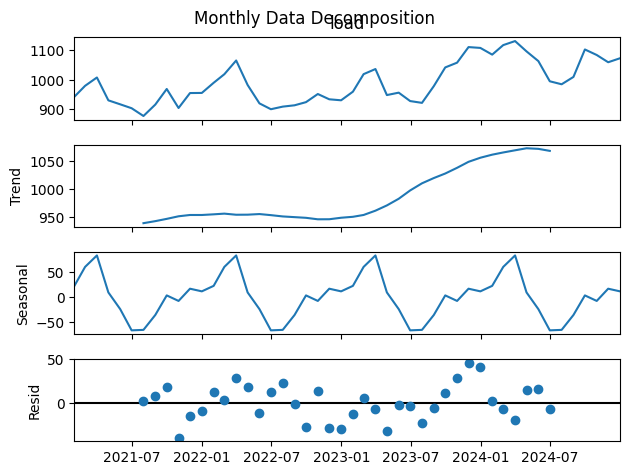

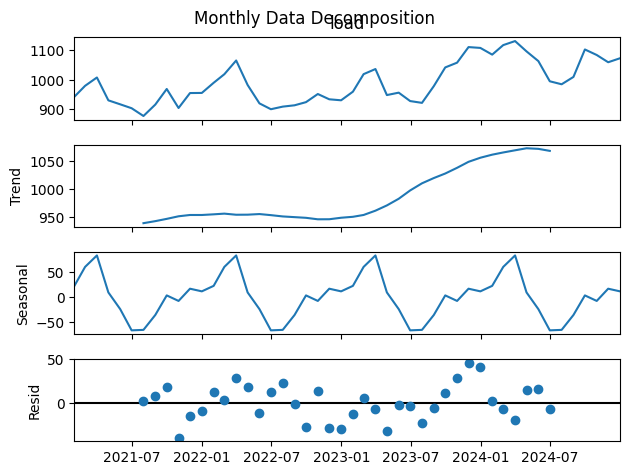

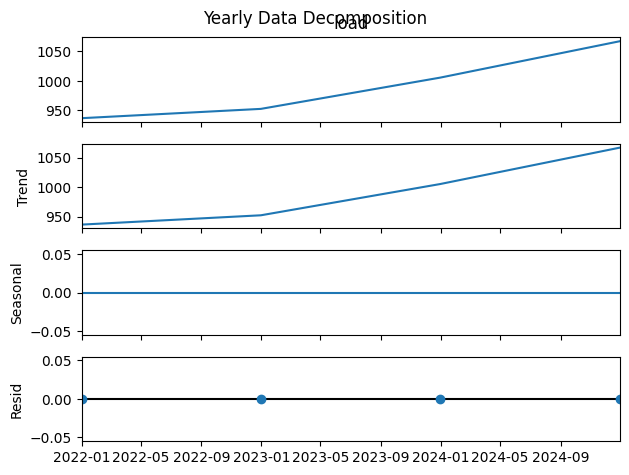

In [ ]:
# Weekly decomposition
decomp_weekly = seasonal_decompose(df_monthly['load'], period=12)
decomp_weekly.plot()
plt.suptitle("Weekly Data Decomposition")
plt.show()

# Monthly decomposition
decomp_monthly = seasonal_decompose(df_monthly['load'], period=12)
decomp_monthly.plot()
plt.suptitle("Monthly Data Decomposition")
plt.show()

# Yearly decomposition (if you have enough data)
if len(df_yearly) > 2:
    decomp_yearly = seasonal_decompose(df_yearly['load'], period=1)
    decomp_yearly.plot()
    plt.suptitle("Yearly Data Decomposition")
    plt.show()


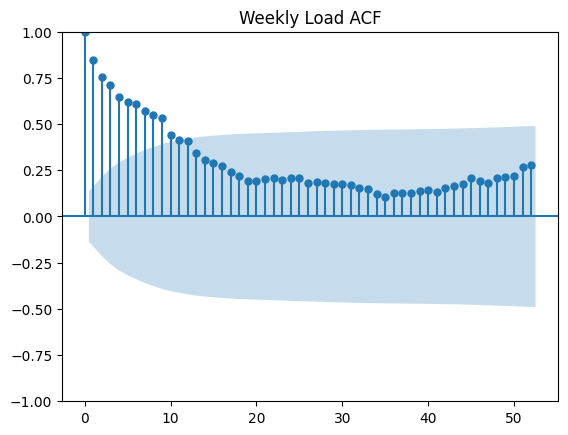

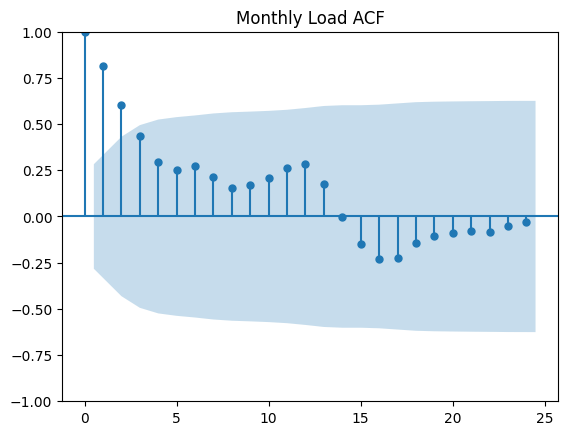

In [142]:
# # plt.figure(figsize=(12, 6))
plot_acf(df_weekly['load'].dropna(), lags=52)
plt.title("Weekly Load ACF")
plt.show()

plot_acf(df_monthly['load'].dropna(), lags=24)
plt.title("Monthly Load ACF")
plt.show()


In [ ]:
plt.figure(figsize=(12, 6))
plot_acf(df_monthly['load'].dropna(), lags=24)
plt.title("Monthly Load ACF")
plt.show()


In [126]:
#Train test split

In [127]:
#pipeline(feature normalization)

In [128]:
#ARIMA (model+eval)

In [129]:
#XGB (model+eval)

In [130]:
#Plot results vs actual values for both cases

In [131]:
#Hyper param tunning (optional)